<a href="https://colab.research.google.com/github/Edwin334/CanvasSAM/blob/main/sam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Using device: cuda


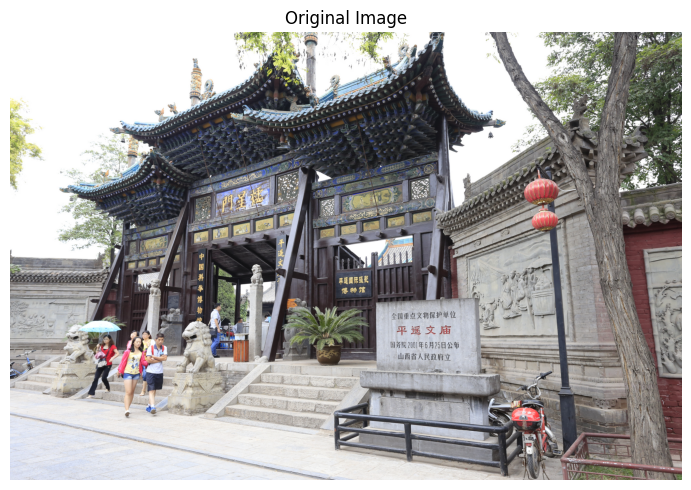

In [1]:
# @title 1. Setup: Install Dependencies, Define Helpers, Config

!pip install -q opencv-python-headless Pillow numpy replicate torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip install -q segment-anything transformers groundingdino-py huggingface_hub


import os
import numpy as np
import torch
import replicate
import cv2
from PIL import Image
import requests
from io import BytesIO
from IPython.display import display, Markdown
import matplotlib.pyplot as plt


import groundingdino.datasets.transforms as T
from groundingdino.models import build_model
from groundingdino.util import box_ops
from groundingdino.util.inference import predict as dino_predict
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict
from huggingface_hub import hf_hub_download
from segment_anything import sam_model_registry, SamPredictor


REPLICATE_API_TOKEN = "your_api_token_here"
os.environ["REPLICATE_API_TOKEN"] = REPLICATE_API_TOKEN

IMAGE_PATH = "/content/test2.jpg"


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)
    args = SLConfig.fromfile(cache_config_file)
    model = build_model(args)
    args.device = device
    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print(f"GroundingDINO Model loaded from {cache_file} \n => {log}")
    model = model.to(device)
    model.eval()
    return model


def transform_image(image: Image.Image) -> torch.Tensor:
    """Transforms PIL Image for GroundingDINO"""
    transform = T.Compose([
        T.RandomResize([800], max_size=1333),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    image_transformed, _ = transform(image, None)
    return image_transformed

SAM_MODELS = {
    "vit_h": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth",
    "vit_l": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth",
    "vit_b": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
}
CACHE_PATH = os.environ.get("TORCH_HOME", os.path.expanduser("~/.cache/torch/hub/checkpoints"))


VALID_DIMENSIONS = [64, 128, 192, 256, 320, 384, 448, 512, 576, 640, 704, 768, 832, 896, 960, 1024]
def find_largest_valid_dimension_lower_than(dimension):
    dimension = min(dimension, 1024)
    valid_dims = [d for d in VALID_DIMENSIONS if d <= dimension]
    if not valid_dims: return min(VALID_DIMENSIONS)
    return max(valid_dims)

# Display helper
def display_images(images, titles, figsize=(15, 5)):
    if not isinstance(images, list): images = [images]
    if not isinstance(titles, list): titles = [titles]
    plt.figure(figsize=figsize)
    for i, (img_data, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        img = None
        if isinstance(img_data, str) and os.path.exists(img_data):
            try: img = Image.open(img_data).convert("RGB")
            except Exception as e: print(f"Error loading image {img_data}: {e}")
        elif isinstance(img_data, Image.Image): img = img_data.convert("RGB")
        elif isinstance(img_data, np.ndarray): img = Image.fromarray(img_data)
        if img: plt.imshow(img)
        else: plt.text(0.5, 0.5, f'Invalid Image\n{title}', ha='center', va='center')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


def draw_output(image, masks=None, boxes=None, phrases=None, alpha=0.5):
    """Draw masks and/or boxes with phrases on image."""
    if isinstance(image, Image.Image): image = np.array(image.convert("RGB"))
    vis_image = image.copy()
    vis_image_bgr = cv2.cvtColor(vis_image, cv2.COLOR_RGB2BGR)

    if masks is not None and isinstance(masks, torch.Tensor) and masks.numel() > 0:
        color_mask = np.array([255, 0, 0], dtype=np.uint8) # Blue mask (BGR)
        combined_mask_np = np.zeros(masks[0].shape, dtype=bool)
        for i in range(masks.shape[0]):
            mask_np = masks[i].cpu().numpy().astype(bool)
            if mask_np.shape != (vis_image.shape[0], vis_image.shape[1]):
                print(f"Warning: Mask shape {mask_np.shape} mismatch with image {vis_image.shape[:2]}. Skipping mask draw.")
                continue
            combined_mask_np = np.logical_or(combined_mask_np, mask_np)

        vis_image_bgr[combined_mask_np] = vis_image_bgr[combined_mask_np] * (1-alpha) + color_mask * alpha
    elif masks is not None and isinstance(masks, np.ndarray) and masks.size > 0:
         if masks.shape == (vis_image.shape[0], vis_image.shape[1]) and masks.dtype == bool:
            color_mask = np.array([255, 0, 0], dtype=np.uint8) # Blue mask (BGR)
            vis_image_bgr[masks] = vis_image_bgr[masks] * (1-alpha) + color_mask * alpha
         else:
             print(f"Warning: Numpy mask shape {masks.shape} or dtype {masks.dtype} invalid. Skipping mask draw.")


    if boxes is not None and isinstance(boxes, torch.Tensor) and boxes.numel() > 0:
        num_boxes = boxes.shape[0]
        boxes_cpu = boxes.cpu()
        for i in range(num_boxes):
            box = boxes_cpu[i]
            box_coords = box.tolist(); x1, y1, x2, y2 = map(int, box_coords)
            cv2.rectangle(vis_image_bgr, (x1, y1), (x2, y2), (0, 255, 0), 2)
            if phrases is not None and i < len(phrases):
                label = f"{phrases[i]}"

                (w, h), _ = cv2.getTextSize(str(label), cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
                cv2.rectangle(vis_image_bgr, (x1, y1 - 20), (x1 + w, y1), (0, 255, 0), -1)
                cv2.putText(vis_image_bgr, str(label), (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)

    vis_image_rgb = cv2.cvtColor(vis_image_bgr, cv2.COLOR_BGR2RGB)
    return vis_image_rgb


def place_cropped_result_back(original_image_path, inpainted_image_path, mask_path, output_path, crop_box):
    print("--- Compositing Result ---")
    original=Image.open(original_image_path).convert('RGB'); inpainted=Image.open(inpainted_image_path).convert('RGB')
    full_mask=Image.open(mask_path).convert('L'); orig_width,orig_height=original.size; left,top,right,bottom=crop_box
    crop_width=right-left; crop_height=bottom-top
    inpainted_resized=inpainted.resize((crop_width,crop_height),Image.Resampling.LANCZOS)
    print(f"Resized inpainted result from {inpainted.size} back to {inpainted_resized.size}.")
    final_image=original.copy(); final_image.paste(inpainted_resized,(left,top)); original_arr=np.array(original)
    final_arr=np.array(final_image); mask_arr=np.array(full_mask); binary_mask=mask_arr > 128
    if binary_mask.shape != (orig_height,orig_width):
        print(f"Warning: Mask dim {binary_mask.shape} != image dim {(orig_height, orig_width)}. Resizing mask.")
        binary_mask = cv2.resize(mask_arr,(orig_width,orig_height),interpolation=cv2.INTER_NEAREST) > 128
    binary_mask_3d=np.stack([binary_mask]*3,axis=-1); composite_arr=np.where(binary_mask_3d,final_arr,original_arr)
    composite_image=Image.fromarray(composite_arr); composite_image.save(output_path)
    print(f"💾 Final composited image saved to {output_path}"); return output_path



display_images(IMAGE_PATH, "Original Image")

In [2]:
# @title 2. Initialize GroundingDINO and SAM Models


GDINO_REPO_ID = "ShilongLiu/GroundingDINO"
GDINO_FILENAME = "groundingdino_swinb_cogcoor.pth"
GDINO_CONFIG_FILENAME = "GroundingDINO_SwinB.cfg.py"


SAM_MODEL_TYPE = "vit_h"
SAM_CHECKPOINT_URL = SAM_MODELS[SAM_MODEL_TYPE]

grounding_dino_model = None
sam_predictor = None


print("⏳ Loading GroundingDINO model...")
grounding_dino_model = load_model_hf(GDINO_REPO_ID, GDINO_FILENAME, GDINO_CONFIG_FILENAME, device=DEVICE)
print("✅ GroundingDINO model loaded.")


print(f"⏳ Loading SAM model ({SAM_MODEL_TYPE})...")
sam = sam_model_registry[SAM_MODEL_TYPE]()
state_dict = torch.hub.load_state_dict_from_url(SAM_CHECKPOINT_URL, model_dir=CACHE_PATH)
sam.load_state_dict(state_dict, strict=True)
sam.to(device=DEVICE)
sam_predictor = SamPredictor(sam)
print("✅ SAM model and predictor loaded.")
models_loaded = True


⏳ Loading GroundingDINO model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
GroundingDINO Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])
✅ GroundingDINO model loaded.
⏳ Loading SAM model (vit_h)...
✅ SAM model and predictor loaded.



🖼️ Loading image: /content/test2.jpg
🔍 Running GroundingDINO with prompt: 'plant'...


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/groundingdino/models/GroundingDINO/transformer.py:862: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `

GroundingDINO found 3 potential objects.

⏳ Running SAM segmentation for 3 boxes...
✅ SAM generated 3 masks.

🎨 Visualizing Combined GroundingDINO + SAM Output...
💾 Combined visualization saved to /content/gdinio_sam_visualization.jpg


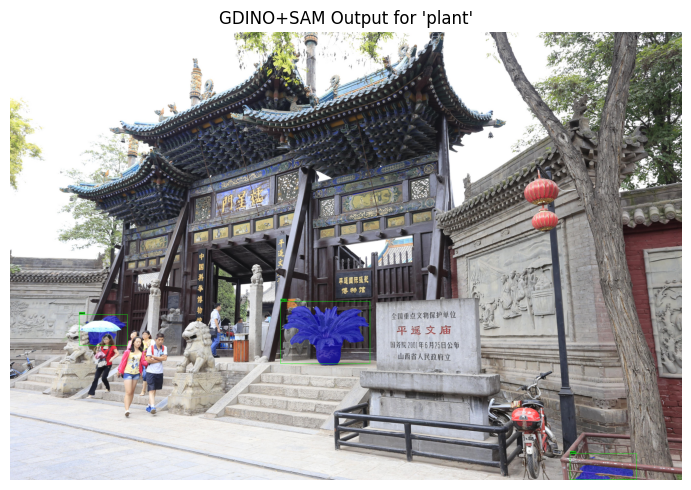

In [3]:
# @title 3. Run Prediction Pipeline (GroundingDINO + SAM) & Visualize SAM Output


TEXT_PROMPT = "plant"      # Object to detect
BOX_THRESHOLD = 0.3        # GroundingDINO confidence threshold for boxes
TEXT_THRESHOLD = 0.25      # GroundingDINO confidence threshold for text match

OUTPUT_VIZ_PATH = "/content/gdinio_sam_visualization.jpg"
OUTPUT_MASK_PATH = "/content/gdinio_sam_mask_full.png"


boxes = None
logits = None
phrases = None
masks = None
pipeline_success = False
image_pil = None

# --- Run Pipeline ---

print(f"\n🖼️ Loading image: {IMAGE_PATH}")
image_pil = Image.open(IMAGE_PATH).convert("RGB")
orig_width, orig_height = image_pil.size

# --- 1. GroundingDINO Prediction ---
print(f"🔍 Running GroundingDINO with prompt: '{TEXT_PROMPT}'...")
image_transformed = transform_image(image_pil)
dino_prompt = TEXT_PROMPT if TEXT_PROMPT.endswith('.') else TEXT_PROMPT + '.'

boxes_raw, logits, phrases = dino_predict(
    model=grounding_dino_model,
    image=image_transformed,
    caption=dino_prompt,
    box_threshold=BOX_THRESHOLD,
    text_threshold=TEXT_THRESHOLD,
    device=DEVICE
)

print(f"GroundingDINO found {len(boxes_raw)} potential objects.")

if len(boxes_raw) > 0:
    processed_boxes_raw = box_ops.box_cxcywh_to_xyxy(boxes_raw)
    scaling_tensor = torch.tensor([orig_width, orig_height, orig_width, orig_height], device=DEVICE)
    boxes = processed_boxes_raw.to(DEVICE) * scaling_tensor # Move boxes_raw to DEVICE first

    # --- 2. SAM Prediction ---
    print(f"\n⏳ Running SAM segmentation for {len(boxes)} boxes...")
    image_np = np.array(image_pil)
    sam_predictor.set_image(image_np)
    transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes.to(DEVICE), image_np.shape[:2])

    masks_raw, _, _ = sam_predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes.to(sam_predictor.device),
        multimask_output=False,
    )
    masks = masks_raw.squeeze(1)
    print(f"✅ SAM generated {masks.shape[0]} masks.")
    pipeline_success = True

    print("\n🎨 Visualizing Combined GroundingDINO + SAM Output...")
    pipeline_vis_image = draw_output(image_pil, masks=masks, boxes=boxes, phrases=phrases)
    pipeline_vis_pil = Image.fromarray(pipeline_vis_image)
    pipeline_vis_pil.save(OUTPUT_VIZ_PATH)
    print(f"💾 Combined visualization saved to {OUTPUT_VIZ_PATH}")
    display_images(OUTPUT_VIZ_PATH, f"GDINO+SAM Output for '{TEXT_PROMPT}'")

else:
    pipeline_success = False



🎯 Selecting best detection...
Selected #0 (Phrase: 'plant', Score: 0.6993)
💾 Creating and saving full-size mask...
Full mask saved to /content/gdinio_sam_mask_full.png

✂️ Cropping image and mask around best detection...
Cropped to 1024x1024 at (2055, 1934, 3079, 2958)
💾 Cropped image and mask saved.


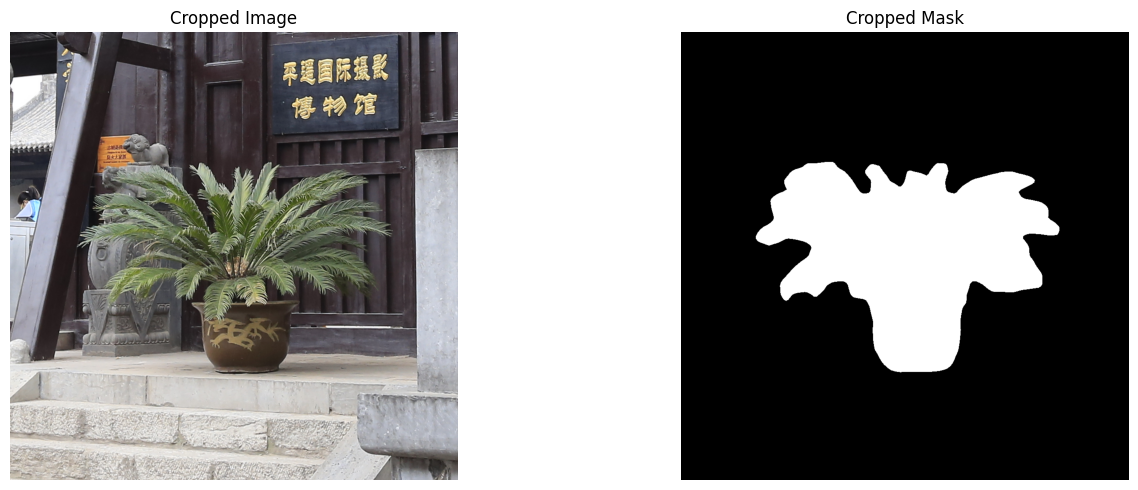

In [4]:
# @title 4. Process Results & Crop Image/Mask

OUTPUT_CROPPED_IMG_PATH = "/content/gdinio_sam_cropped_input.png"
OUTPUT_CROPPED_MASK_PATH = "/content/gdinio_sam_cropped_mask.png"


crop_box_coords = None
crop_width, crop_height = None, None
orig_mask_path = OUTPUT_MASK_PATH
processing_success = False

if pipeline_success:
    print("\n🎯 Selecting best detection...")
    best_idx = logits.argmax()
    best_mask = masks[best_idx]       # (H, W) tensor
    best_box = boxes[best_idx]        # (4,) tensor [x1, y1, x2, y2]
    best_phrase = phrases[best_idx]
    best_logit = logits[best_idx]
    print(f"Selected #{best_idx.item()} (Phrase: '{best_phrase}', Score: {best_logit:.4f})")

    print("💾 Creating and saving full-size mask...")
    mask_np = best_mask.cpu().numpy().astype(bool)
    full_mask_image_np = np.zeros((orig_height, orig_width, 3), dtype=np.uint8)
    full_mask_image_np[mask_np] = [255, 255, 255]
    full_mask_image = Image.fromarray(full_mask_image_np)
    full_mask_image.save(OUTPUT_MASK_PATH)
    print(f"Full mask saved to {OUTPUT_MASK_PATH}")
    # display_images(OUTPUT_MASK_PATH, "Generated Full-Size Mask (Best Detection)")


    print("\n✂️ Cropping image and mask around best detection...")
    x1, y1, x2, y2 = map(int, best_box.cpu().tolist())
    target_crop_size = 1024
    center_x, center_y = (x1 + x2) / 2, (y1 + y2) / 2
    half_size = target_crop_size / 2

    left = int(max(0, center_x - half_size)); top = int(max(0, center_y - half_size))
    right = int(min(orig_width, left + target_crop_size)); bottom = int(min(orig_height, top + target_crop_size))

    left,top,right,bottom = max(0,left),max(0,top),min(orig_width,right),min(orig_height,bottom)
    crop_box_coords = (left, top, right, bottom)

    cropped_img = image_pil.crop(crop_box_coords)

    cropped_mask = full_mask_image.crop(crop_box_coords)
    crop_width, crop_height = cropped_img.size

    cropped_img.save(OUTPUT_CROPPED_IMG_PATH)
    cropped_mask.save(OUTPUT_CROPPED_MASK_PATH)
    print(f"Cropped to {crop_width}x{crop_height} at {crop_box_coords}")
    print(f"💾 Cropped image and mask saved.")
    display_images([OUTPUT_CROPPED_IMG_PATH, OUTPUT_CROPPED_MASK_PATH], ["Cropped Image", "Cropped Mask"])

    processing_success = True

else:
    print("🛑 Skipping processing/cropping because prediction pipeline failed or was skipped.")

Dimensions for Replicate API call: 1024x1024

⏳ Running Stable Diffusion Inpainting via Replicate...
✅ Inpainting completed. Output URL: https://replicate.delivery/yhqm/3rN3pFcPnsbpIV6cqgbQnsQ5sEzOG3X82WLDyjKaOsFVBIIF/out-0.png
💾 Inpainted crop saved to /content/inpainted_crop_gdino_sam.png

Displaying raw output from the diffusion model (inpainted crop):


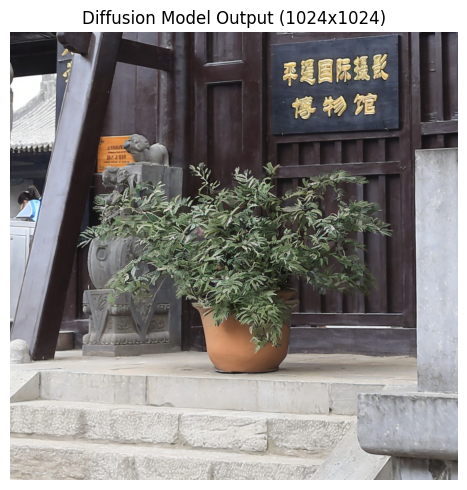

--- Compositing Result ---
Resized inpainted result from (1024, 1024) back to (1024, 1024).
💾 Final composited image saved to /content/final_output_gdino_sam.png

Displaying final comparison:


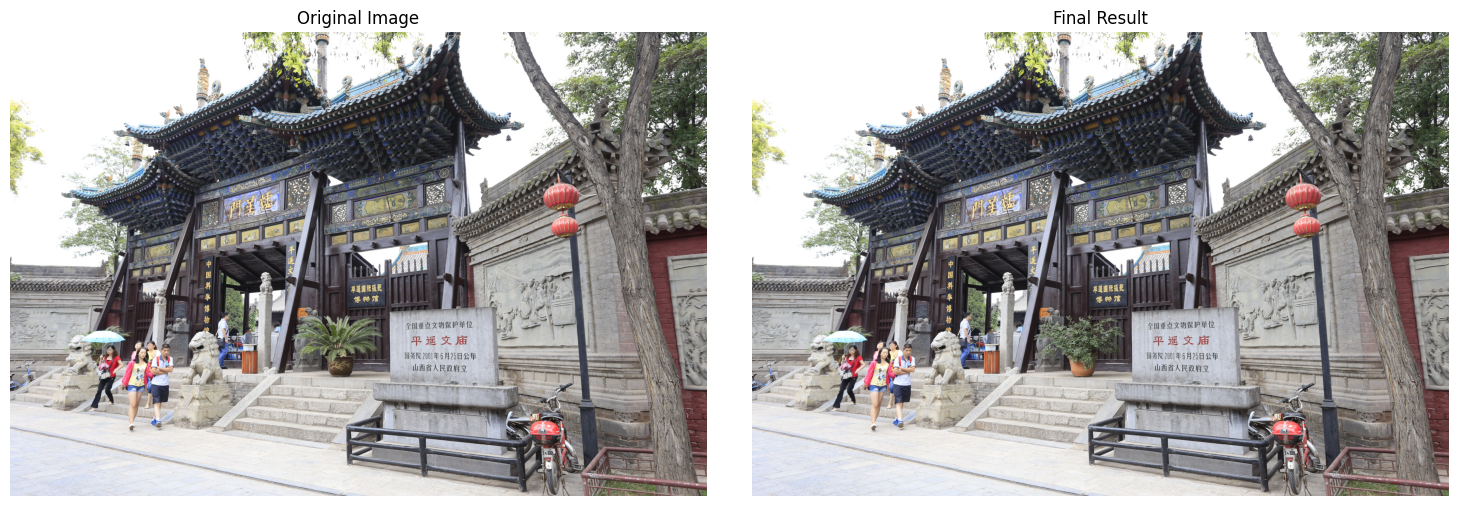

In [5]:
# @title 5. Run Replicate Inpainting and Composite Result

import os
from PIL import Image
import requests

# --- ADD THESE DEFINITIONS ---
EDIT_PROMPT = "a beautiful terracotta pot plant" # Or your desired prompt
INPAINTED_CROP_PATH = "/content/inpainted_crop_gdino_sam.png"
FINAL_OUTPUT_PATH = "/content/final_output_gdino_sam.png"

if 'crop_width' in locals() and crop_width is not None:
    api_width = find_largest_valid_dimension_lower_than(crop_width)
    # ... and so on

if 'crop_width' in locals() and crop_width is not None:
    api_width = find_largest_valid_dimension_lower_than(crop_width)
    api_height = find_largest_valid_dimension_lower_than(crop_height)
    print(f"Dimensions for Replicate API call: {api_width}x{api_height}")

    # --- Run Replicate Inpainting ---
    print("\n⏳ Running Stable Diffusion Inpainting via Replicate...")
    try:
        # Assume OUTPUT_CROPPED_IMG_PATH and MASK path are correct
        output = replicate.run(
            # Using specific model hash from user input
            "stability-ai/stable-diffusion-inpainting:95b7223104132402a9ae91cc677285bc5eb997834bd2349fa486f53910fd68b3",
            input={
                "prompt": EDIT_PROMPT,
                "image": open(OUTPUT_CROPPED_IMG_PATH, "rb"),
                "mask": open(OUTPUT_CROPPED_MASK_PATH, "rb"),
                "num_inference_steps": 50,
                "guidance_scale": 7.5,
                "scheduler": "DPMSolverMultistep",
                "width": api_width,
                "height": api_height
            }
        )

        # --- Process Output ---
        if output:
            output_url = output[0] if isinstance(output, list) else output
            if output_url:
                print(f"✅ Inpainting completed. Output URL: {output_url}")
                response = requests.get(output_url)
                response.raise_for_status()
                with open(INPAINTED_CROP_PATH, "wb") as f:
                    f.write(response.content)
                print(f"💾 Inpainted crop saved to {INPAINTED_CROP_PATH}")

                # Display diffusion output
                print("\nDisplaying raw output from the diffusion model (inpainted crop):")
                inpainted_img_api_size = Image.open(INPAINTED_CROP_PATH)
                api_output_w, api_output_h = inpainted_img_api_size.size
                display_images(INPAINTED_CROP_PATH, f"Diffusion Model Output ({api_output_w}x{api_output_h})")

                # Composite result
                # Ensure orig_mask_path and crop_box_coords exist from Cell 4
                final_output_image_path = place_cropped_result_back(
                    IMAGE_PATH, INPAINTED_CROP_PATH, orig_mask_path,
                    FINAL_OUTPUT_PATH, crop_box_coords
                )

                # Display final comparison
                if final_output_image_path and os.path.exists(final_output_image_path):
                    print("\nDisplaying final comparison:")
                    display_images([IMAGE_PATH, final_output_image_path],
                                   ["Original Image", "Final Result"])
                else:
                    print("🛑 Compositing failed or output file not found.")
            else:
                print("🛑 Replicate returned an empty or invalid URL.")
        else:
            print("🛑 Replicate did not return an output.")

    # Minimal error handling as requested previously
    except Exception as e:
        print(f"🛑 An error occurred: {e}")
        # Optional: import traceback; traceback.print_exc()

else:
    print("🛑 Skipping Replicate step: Required variables missing. Re-run previous cells.")

✅ Models loaded and image path found. Starting demos...

--- Running Demo 1/3: Editing 'Umbrella' ---
Edit prompt: 'a fancier umbrella'

🔍 Running GroundingDINO with prompt: 'Umbrella'...
GroundingDINO found 1 potential 'Umbrella' objects.
⏳ Running SAM segmentation...
✅ SAM generated 1 masks.

🎯 Processing results and cropping...
Selected detection #0 ('umbrella', Score: 0.5048)
Full mask saved to /content/gdinio_sam_mask_full_umbrella.png
Cropped to 1024x1024. Files saved.

--- Preparing Inpainting for 'Umbrella' ---
API dimensions: 1024x1024
⏳ Running Replicate Inpainting...
✅ Inpainting completed.
💾 Inpainted crop saved to /content/inpainted_crop_gdino_sam_umbrella.png
--- Compositing Result ---
Resized inpainted result from (1024, 1024) back to (1024, 1024).
💾 Final composited image saved to /content/final_output_gdino_sam_umbrella.png
✅ Successfully composited final image for 'Umbrella'.

--- Running Demo 2/3: Editing 'steps' ---
Edit prompt: 'steps with a fancy pepsi logo'

🔍 Ru

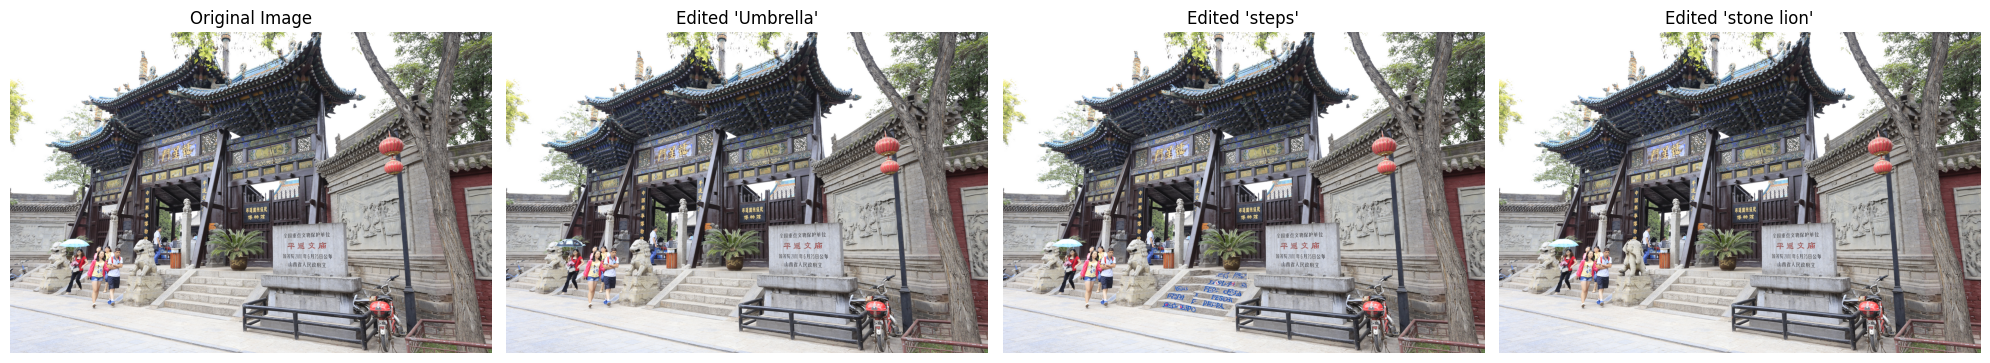

In [6]:
import time
import requests
from PIL import Image
import numpy as np
import torch
import torchvision.ops.boxes as box_ops
from torchvision.ops import box_convert


demos = [
    {
        "target_object": "Umbrella",
        "edit_prompt": "a fancier umbrella",
        "suffix": "umbrella"
    },
    {
        "target_object": "steps",
        "edit_prompt": "steps with a fancy pepsi logo",
        "suffix": "steps"
    },
    {
        "target_object": "stone lion",
        "edit_prompt": "a stone elephent",
        "suffix": "lion"
    },
]

final_image_paths = {}

if 'models_loaded' in locals() and models_loaded and IMAGE_PATH:
    print("✅ Models loaded and image path found. Starting demos...")

    for i, demo in enumerate(demos):
        TEXT_PROMPT = demo["target_object"]
        EDIT_PROMPT = demo["edit_prompt"]
        suffix = demo["suffix"]
        print(f"\n--- Running Demo {i+1}/{len(demos)}: Editing '{TEXT_PROMPT}' ---")
        print(f"Edit prompt: '{EDIT_PROMPT}'")

        OUTPUT_VIZ_PATH = f"/content/gdinio_sam_visualization_{suffix}.jpg"
        OUTPUT_MASK_PATH = f"/content/gdinio_sam_mask_full_{suffix}.png"
        OUTPUT_CROPPED_IMG_PATH = f"/content/gdinio_sam_cropped_input_{suffix}.png"
        OUTPUT_CROPPED_MASK_PATH = f"/content/gdinio_sam_cropped_mask_{suffix}.png"
        INPAINTED_CROP_PATH = f"/content/inpainted_crop_gdino_sam_{suffix}.png"
        FINAL_OUTPUT_PATH = f"/content/final_output_gdino_sam_{suffix}.png"

        boxes, logits, phrases, masks = None, None, None, None
        pipeline_success, processing_success = False, False
        crop_box_coords, crop_width, crop_height = None, None, None
        orig_mask_path = OUTPUT_MASK_PATH

        print(f"\n🔍 Running GroundingDINO with prompt: '{TEXT_PROMPT}'...")

        image_pil = Image.open(IMAGE_PATH).convert("RGB")
        orig_width, orig_height = image_pil.size

        image_transformed = transform_image(image_pil)
        dino_prompt = TEXT_PROMPT if TEXT_PROMPT.endswith('.') else TEXT_PROMPT + '.'

        boxes_raw, logits, phrases = dino_predict(
            model=grounding_dino_model, image=image_transformed, caption=dino_prompt,
            box_threshold=BOX_THRESHOLD, text_threshold=TEXT_THRESHOLD, device=DEVICE
        )
        print(f"GroundingDINO found {len(boxes_raw)} potential '{TEXT_PROMPT}' objects.")

        if len(boxes_raw) > 0:
            processed_boxes_raw = box_convert(boxes_raw, in_fmt="cxcywh", out_fmt="xyxy")
            scaling_tensor = torch.tensor([orig_width, orig_height, orig_width, orig_height], device=DEVICE)
            boxes = processed_boxes_raw.to(DEVICE) * scaling_tensor

            print(f"⏳ Running SAM segmentation...")
            image_np = np.array(image_pil)
            sam_predictor.set_image(image_np)
            transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes.to(DEVICE), image_np.shape[:2])
            masks_raw, _, _ = sam_predictor.predict_torch(
                point_coords=None, point_labels=None, boxes=transformed_boxes.to(sam_predictor.device),
                multimask_output=False,
            )
            masks = masks_raw.squeeze(1)
            print(f"✅ SAM generated {masks.shape[0]} masks.")
            pipeline_success = True
        else:
            print(f"🛑 GroundingDINO did not detect '{TEXT_PROMPT}'. Skipping SAM and remaining steps for this demo.")
            pipeline_success = False


        if pipeline_success:
            print("\n🎯 Processing results and cropping...")
            best_idx = logits.argmax(); best_mask = masks[best_idx]; best_box = boxes[best_idx]
            best_phrase = phrases[best_idx]; best_logit = logits[best_idx]
            print(f"Selected detection #{best_idx.item()} ('{best_phrase}', Score: {best_logit:.4f})")

            mask_np = best_mask.cpu().numpy().astype(bool)
            full_mask_image_np = np.zeros((orig_height, orig_width, 3), dtype=np.uint8)
            full_mask_image_np[mask_np] = [255, 255, 255]
            full_mask_image = Image.fromarray(full_mask_image_np)
            full_mask_image.save(OUTPUT_MASK_PATH)
            print(f"Full mask saved to {OUTPUT_MASK_PATH}")

            x1, y1, x2, y2 = map(int, best_box.cpu().tolist())
            target_crop_size=1024; center_x=(x1+x2)/2; center_y=(y1+y2)/2; half_size=target_crop_size/2
            left=int(max(0, center_x - half_size)); top=int(max(0, center_y - half_size))
            right=int(min(orig_width, left + target_crop_size)); bottom=int(min(orig_height, top + target_crop_size))
            left,top,right,bottom=max(0,left),max(0,top),min(orig_width,right),min(orig_height,bottom)
            crop_box_coords=(left,top,right,bottom)

            cropped_img = image_pil.crop(crop_box_coords)
            cropped_mask = full_mask_image.crop(crop_box_coords)
            crop_width, crop_height = cropped_img.size

            cropped_img.save(OUTPUT_CROPPED_IMG_PATH)
            cropped_mask.save(OUTPUT_CROPPED_MASK_PATH)
            print(f"Cropped to {crop_width}x{crop_height}. Files saved.")
            processing_success = True


        if processing_success:
            print(f"\n--- Preparing Inpainting for '{TEXT_PROMPT}' ---")
            api_width = find_largest_valid_dimension_lower_than(crop_width)
            api_height = find_largest_valid_dimension_lower_than(crop_height)
            print(f"API dimensions: {api_width}x{api_height}")

            print("⏳ Running Replicate Inpainting...")
            output = replicate.run(
                "stability-ai/stable-diffusion-inpainting:c28b92a7ecd66eee4aefcd8a94eb9e7f6c3805d5f06038165407fb5cb355ba67",
                input={
                    "prompt": EDIT_PROMPT, "image": open(OUTPUT_CROPPED_IMG_PATH, "rb"),
                    "mask": open(OUTPUT_CROPPED_MASK_PATH, "rb"), "num_inference_steps": 50,
                    "guidance_scale": 7.5, "scheduler": "DPMSolverMultistep",
                    "width": api_width, "height": api_height
                }
            )

            if output:
                output_url = output[0] if isinstance(output, list) else output
                print(f"✅ Inpainting completed.")
                response = requests.get(output_url); response.raise_for_status()
                with open(INPAINTED_CROP_PATH, "wb") as f: f.write(response.content)
                print(f"💾 Inpainted crop saved to {INPAINTED_CROP_PATH}")

                final_file = place_cropped_result_back(
                    IMAGE_PATH, INPAINTED_CROP_PATH, orig_mask_path, FINAL_OUTPUT_PATH, crop_box_coords
                )
                if final_file:
                    final_image_paths[suffix] = final_file
                    print(f"✅ Successfully composited final image for '{TEXT_PROMPT}'.")
                else:
                    print(f"🛑 Compositing failed for '{TEXT_PROMPT}'.")
            else:
                print(f"🛑 Replicate returned no output for '{TEXT_PROMPT}'.")

        else:
            print(f"Skipping inpainting/compositing for '{TEXT_PROMPT}' due to previous errors.")

    print("\n--- FINAL DEMO RESULTS ---")
    display_titles = ["Original Image"]
    display_paths = [IMAGE_PATH]

    for demo in demos:
        suffix = demo["suffix"]
        if suffix in final_image_paths:
            display_titles.append(f"Edited '{demo['target_object']}'")
            display_paths.append(final_image_paths[suffix])
        else:
            print(f"Note: Demo for '{demo['target_object']}' failed or was skipped.")

    if len(display_paths) > 1:
         display_images(display_paths, display_titles, figsize=(5 * len(display_paths), 5))
    else:
         print("No successful demos to display.")

else:
    print("🛑 Cannot run demos. Ensure models are loaded (Cell 2) and IMAGE_PATH is valid (Cell 1).")